# Genetic Algorithm for Truck Routing Problem

Implementation of genetic algorithm for solving the truck routing problem. 

The problem is defined as follows:
- There are n orders that need to be delivered by a truck.
- There are m fuel stations where the truck can refuel.
- The truck starts at the base and needs to visit all orders in the most efficient way.
- The truck has a limited fuel tank capacity and needs to refuel at stations.
- The goal is to minimize the total cost of the route, including fuel costs and penalties for running out of fuel.
- The truck can carry multiple orders at once, but the total mass cannot exceed the truck's capacity.
- The truck can only refuel at stations, not during the route.
- The orders and fuel stations are randomly generated and have random locations and weights.
- The fuel consumption is proportional to the total mass of the truck.
- The fuel price varies between stations.
- The base location is fixed at coordinates (0, 0).

GENERAL STRATEGY:
- generate population
- evaluate population
- selection
- crossover
- mutation
- repeat until convergence

All the parameters of the problem are defined in the last cells of this notebook. 

In [849]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt

## Generate starting population

In [850]:
def generate_starting_population( df_stations, df_orders, population_size=10, print_results=False):
    original_list = df_orders.index.tolist()
    
    n_stations = len(df_stations)
    population = []
        
    for i in range(population_size):
        sample = [0]
        random_permutation = random.sample(original_list, len(original_list))
        
        for j in range(len(random_permutation)):
            sample.append(random_permutation[j])
            
            if j != len(random_permutation)-1:
                if random.randint(0, 1) == 1:
                    station_ID = random.randint(1, n_stations-1)
                else:
                    station_ID = 1
        
                sample.append(station_ID)
        # print(sample)
        sample.append(0)
        population.append(sample)
        
    if print_results:
        # print(f"Permutacja: {original_list}")
        print("STARTING POPULATION")
        for j in population:
            print(j)
        print("\n")
    return population

## Evaluate population

In [851]:
def evaluate_step(a, b, current_mass, fuel_level, fuel_penalty=1000, max_fuel=150, print_results=False):

    step_cost = 0
    
    # city - city -> no station
    if isinstance(a, str) & isinstance(b, str):
        
        distance = (abs(df_orders.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_orders.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            # print("YOU RAN OUT OF FUEL!")
            
        current_mass += df_orders.loc[b, 'mass']
        
        if print_results:
            print(f"City {a} to city {b}. Distance: {distance} km")
            print(f"{df_orders.loc[b, 'mass']} kg has been loaded. We have {current_mass} on truck")
            print("fuel_level: ", fuel_level)

            
        
    elif isinstance(a, str):

        if b != 1:
            if b == 0:
                df_stations.loc[b, 'latitude'] = float(0)
                df_stations.loc[b, 'longitude'] = float(0)
                df_stations.loc[b, 'price'] = 5.17
    
            distance = (abs(df_orders.loc[a, 'longitude'] - df_stations.loc[b, 'longitude']) + 
                        abs(df_orders.loc[a, 'latitude'] - df_stations.loc[b, 'latitude']))
    
            fuel_level = fuel_level - distance * fuel_consumption(current_mass)
    
            # print("fuel_level: ", fuel_level)
    
            if fuel_level < 0:
                step_cost += fuel_penalty
                # print("YOU RAN OUT OF FUEL!")
                
    
            step_cost += df_stations.loc[b, 'price'] * (max_fuel - fuel_level)
    
            if print_results:
                print(f"City {a} to station {b}. Distance: {distance} km")
                print(f"Refueled {(max_fuel - fuel_level)} liters for {df_stations.loc[b, 'price'] * (max_fuel - fuel_level)} PLN" )
                print("current_mass: ", current_mass)
                
            fuel_level = max_fuel

    # Station to city        
    else:
        
        if a == 0:
            df_stations.loc[a, 'latitude'] = float(0)
            df_stations.loc[a, 'longitude'] = float(0)
        
        distance = (abs(df_stations.loc[a, 'longitude'] - df_orders.loc[b, 'longitude']) + 
                    abs(df_stations.loc[a, 'latitude'] - df_orders.loc[b, 'latitude']))

        fuel_level = fuel_level - distance * fuel_consumption(current_mass)
        
        if fuel_level < 0:
            step_cost += fuel_penalty
            # print("YOU RAN OUT OF FUEL!")
            
        current_mass += df_orders.loc[b, 'mass']
        
        if print_results:
            print(f"Station {a} to city {b}. Distance: {distance} km")
            print(f"{df_orders.loc[b, 'mass']} kg has been loaded. We have {current_mass} on truck")
            print("fuel_level: ", fuel_level)

    return current_mass, fuel_level, step_cost


In [852]:
def evaluate_case(sample, print_results=False):
    total_cost = 0
    fuel_level = 150
    current_mass = 1

    if print_results:
        print("STARTING EVALUATION")
        print(f"START FUEL: {fuel_level}")
        print(f"sample: {sample}")    

    for i in range(len(sample)-1):
        
        if sample[i] == 1:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i-1], sample[i+1], current_mass, fuel_level)
        else:
            current_mass, fuel_level, step_cost = evaluate_step(sample[i], sample[i+1], current_mass, fuel_level)
        
        total_cost += step_cost
        if print_results:
            print(f"Step {i}: {step_cost}")
            print(f"Current cost: {total_cost}")
    
    
    return total_cost

In [853]:
def evaluate_population(population, print_results=False):
    population_results = {'samples': population, 'costs': []}
    top_samples = []
    
    for sample in population:
        population_results['costs'].append(evaluate_case(sample))
        
    # Extract samples and costs
    samples = population_results['samples']
    costs = population_results['costs']
    
    # Pair each sample with its corresponding cost
    paired_samples_costs = list(zip(samples, costs))
    
    # Sort the pairs by the cost (second element in each pair)
    sorted_pairs = sorted(paired_samples_costs, key=lambda x: x[1])
    
    # Extract the top 3 samples
    top_samples = [item for item in sorted_pairs[:3]]

    if print_results:
        for i in range(len(top_samples)):
            print(f"{top_samples[i][0]} results: {top_samples[i][1]}")
    
    return population_results, top_samples


## Selection

In [854]:
def selection_tournament(population_results, k=2, n=10):
    # population_results - populacja podana w formie słownika z wartościami funkcji kosztu
    # parametr k - wielkość próbki (wielkość turnieju)
    # parametr n - liczba osobników do wyselekcjonowania
    selected_individuals = []
    population_size = len(population_results['samples'])

    for _ in range(n):
        # Losowo wybierz indeksy osobników do turnieju
        tournament_indices = random.sample(range(population_size), k)
        
        # Znajdź najlepszy osobnik w turnieju
        best_index = tournament_indices[0]
        for idx in tournament_indices:
            if population_results['costs'][idx] < population_results['costs'][best_index]:
                best_index = idx
        
        # Dodaj wybranego osobnika do listy wybranych osobników
        selected_individuals.append(population_results['samples'][best_index])
    
    return selected_individuals
    

In [855]:
import random

def selection_by_probability(population_results):
    
    n = len(population_results['samples'])
    selected_population = []
    
    max_cost = max(population_results['costs'])
    # print(f"max_cost: {max_cost}")
    min_cost = min(population_results['costs'])    
    # print(f"min_cost: {min_cost}")
    
    if max_cost == min_cost:
        return population_results['samples'], True
    else:
        for i in range(n):
            # Calculate the decision probability
    
            # If max cost = 100, and cost = 1, then decision_probability = 0.99
            # If max cost = 100, and cost = 100, then decision_probability = 0
            decision_probability = 1 -  ( population_results['costs'][i] - min_cost ) / ( max_cost - min_cost + 1e-6 )
            # print(f"decision_probability: {decision_probability}")
            
            # Generate a random number and decide based on the decision probability
            if random.random() < decision_probability:
                selected_population.append(population_results['samples'][i])
    
    
    
    return selected_population, False


assert (selection_by_probability({'samples': [1, 2, 3, 4], 'costs': [10, 20, 30, 40]}) == 
        ([1, 2, 3], False) or 
        ([1, 2, 4], False) or 
        ([1, 3, 4], False) or 
        ([2, 3, 4], False))


## Cross-over



In [856]:
# WARNING  - MIN 2 STATIONS

def cross_over(parent1, parent2, random_crossover_point=True, print_results=False):
    # parent1, parent2 - crossover parents
    # Return a child
    
    # Select a random crossover point
    if random_crossover_point:
        crossover_point_1 = random.randint(1, len(parent1)-2)
        crossover_point_2 = random.randint(crossover_point_1 + 1, len(parent1) - 1)
    else:
        crossover_point_1 = 3
        crossover_point_2 = 5
    
    if print_results:
        print(f"Cross-over points: {crossover_point_1}, {crossover_point_2}")
    
    child1 = parent1.copy()
    
    for i in range(len(parent1)):
        if i%2 != 0:
            if i >= crossover_point_1 and i <= crossover_point_2:
                if print_results:
                    print(f"\nCross-over at {i} place")
                original_spot_value = child1[i]
                to_insert = parent2[i]
                
                if print_results:
                    print(f"original_spot_value: {original_spot_value}")
                    print(f"to_insert: {to_insert}")
                
                taken_spot_index = child1.index(to_insert)
                taken_spot_value = child1[taken_spot_index]
                
                if print_results:
                    print(f"taken_spot_index: {taken_spot_index}, taken_spot_value: {taken_spot_value}")
                
                for k in range(len(parent1)):
                    if taken_spot_index >= crossover_point_1 and taken_spot_index < crossover_point_2:
                        taken_spot_value = child1[taken_spot_index]
                        taken_spot_index = child1.index(taken_spot_value)
                        
                        if taken_spot_value == parent2[taken_spot_index]:
                            break
                    else:
                        break
                    
                    if print_results:
                        print(f"taken_spot_index: {taken_spot_index}, taken_spot_value: {taken_spot_value}")
                    
                child1[taken_spot_index] = original_spot_value
                
                #TODO - between crossover points get stations from second parent
                
                child1[i] = to_insert
                
    return child1

# HAPPY PATH
assert cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 6, 0, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0], random_crossover_point=False) == [0, 1, 0, 5, 0, 4, 0, 3, 0, 2, 0, 6, 0]
assert cross_over([0, 6, 0, 5, 0, 4, 0, 3, 0, 2, 0, 1, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], random_crossover_point=False) == [0, 6, 0, 2, 0, 3, 0, 4, 0, 5, 0, 1, 0]

# SIMPLEST PATH
assert cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], random_crossover_point=False) == [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0]

# HARD PATH
assert cross_over([0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], [0, 6, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0], random_crossover_point=False) == [0, 3, 0, 1, 0, 2, 0, 4, 0, 5, 0, 6, 0]
assert cross_over([0, 6, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0], [0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0], random_crossover_point=False) == [0, 6, 0, 2, 0, 3, 0, 1, 0, 4, 0, 5, 0]

In [857]:
def crossover_population(selected_population):
    random.shuffle(selected_population)
    crossover_population = []
    
    for i in range(len(selected_population)//2):
        child1 = cross_over(selected_population[i], selected_population[len(selected_population)-i-1])
        child2 = cross_over(selected_population[len(selected_population)-i-1], selected_population[i])
        crossover_population.append(child1)
        crossover_population.append(child2)
        
    return crossover_population

In [858]:
def crossover_population_prob(selected_population, population_size=int(0.9*10)):
    
    crossover_population = selected_population
    starting_len = len(selected_population)
    
    for i in range(population_size - starting_len):
        random1 = random.randint(0, len(selected_population)-1)
        random2 = random.randint(0, len(selected_population)-1)
        
        child = cross_over(crossover_population[random1], crossover_population[random2])
        crossover_population.append(child)
    
    return crossover_population

## Mutation

In [859]:
def mutate_in_place(pop, prob_switch, prob_station):
    for i in range(1, len(pop)-2):
        dice_roll = random.random()
        if i%2 == 0:
            if dice_roll <= prob_station:
                roll2 = random.random()
                if roll2 < 0.5:
                    pop[i] = 0
                else:
                    pop[i] = random.randint(2, len(df_stations))
        else:
            if dice_roll <= prob_switch:
                if i > 1:
                    temp = pop[i-2]
                    pop[i-2] = pop[i]
                    pop[i] = temp
    return pop
            

In [860]:
import random
    
def mutate_prob(population, population_size=10, print_results=False):
    starting_len = len(population)
    
    for i in range(population_size - starting_len):
        chosen_case_index = random.randint(0, starting_len)
        chosen_case = population[chosen_case_index]

        # Parameters for the Gaussian distribution
        mean = starting_len/2
        std_dev = mean/3
        no_of_mutations = round(random.gauss(mean, std_dev))
        
        if print_results:
            print("no_of_mutations: ", no_of_mutations)
        
        random_swaps = []
        for j in range(no_of_mutations):
            mutation_index = random.randint(1, len(chosen_case)-2)
            
            if mutation_index %2 == 0:
                chosen_case[mutation_index] = random.randint(0, n_stations) + 1
            else:
                random_swaps.append(mutation_index)
                    
        for j in range(len(random_swaps)//2):
            chosen_case[random_swaps[j]], chosen_case[random_swaps[len(random_swaps) - j - 1]] = chosen_case[random_swaps[len(random_swaps) - j - 1]], chosen_case[random_swaps[j]]
            
        population.append(chosen_case)

    return population
        
    
                

In [861]:
def GA_tournament(start_population, max_generations):
    pop = start_population
    for generation in range(max_generations):
        evaluated_pop, _ = evaluate_population(pop, print_results=False)
        selected_pop = selection_tournament(evaluated_pop, 2, len(pop))
        crossed_pop = crossover_population(selected_pop)
        mutated_pop = mutate_in_place(crossed_pop, 0.05, 0.1)
        pop = mutated_pop
    
    final_evaluated_pop = evaluate_population(pop, print_results=False)
        
    # Sortowanie słownika według wartości w porządku malejącym
    sorted_items = sorted(final_evaluated_pop.items(), key=lambda item: item[1], reverse=True)
    # sorted_items = sorted(pop.items(), key=lambda item: item[1], reverse=True)


    # Wybór 10 kluczy o największych wartościach
    top_10_keys = [item[0] for item in sorted_items[:10]]
    
    print("Najlepsze 10 rozwiązań:")
    # Wyświetlenie 10 kluczy
    print(top_10_keys)
        

In [862]:
def GA_prob(start_population, max_generations, population_size=10, print_results=False):
    
    population = start_population

    sample_history = []

    for generation in range(max_generations):
        if print_results:
            print(f"GENERATION: {generation}")
            
        population_evaluated, top_samples = evaluate_population(population, print_results=print_results)
        sample_history.append(top_samples)
        selected_pop, break_flag = selection_by_probability(population_evaluated)
        crossed_pop  = crossover_population_prob(selected_pop, population_size)
        mutated_pop = mutate_prob(crossed_pop, population_size)
        population = mutated_pop
        
        if break_flag:
            break
        
    if print_results:
        print(f"FINAL GENERATION")
    
    final_evaluated_pop, top_samples = evaluate_population(population, print_results=print_results)
    
    sample_history.append(top_samples)
    
    return final_evaluated_pop, sample_history

## Plot scores and world map

In [863]:
import matplotlib.pyplot as plt

def plot_scores(sample_history):

    # Extract scores for each generation
    generations = list(range(0, len(sample_history)))
    scores = [list(zip(*gen))[1] for gen in sample_history]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    # Assuming there are always 3 tuples in each generation
    plt.plot(generations, [gen[0] for gen in scores], marker='o', label=f'Best case', color='green')
    plt.plot(generations, [gen[1] for gen in scores], marker='o', label=f'Second case', color='orange')
    plt.plot(generations, [gen[2] for gen in scores], marker='o', label=f'Third case', color='deepskyblue')
    
    plt.xlabel('Generation Number')
    plt.ylabel('Scores')
    plt.title('Scores by Generation')
    plt.legend()
    plt.grid(True)
    plt.show()


In [864]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_world(df_orders, df_stations, base_location, best_path):
    # Extract the coordinates for the best path
    path_coords = [base_location]
    for item in best_path:
        if isinstance(item, int):
            station = df_stations.iloc[item]
            if not station.empty and item != 0 and item != 1:
                path_coords.append((station['latitude'], station['longitude']))
        elif isinstance(item, str):
            order = df_orders.loc[item]  # Adjust for 0-based index
            if not order.empty:
                path_coords.append((order['latitude'], order['longitude']))
    
    path_coords.append(base_location)  # Return to the base at the end

    # Plot orders and stations on a map
    plt.figure(figsize=(10, 6))
    
    # Plot base location
    plt.scatter(base_location[0], base_location[1], c='blue', label='Base', s=100, marker='s')
    plt.text(base_location[0], base_location[1], 'Base', fontsize=12, verticalalignment='bottom')
    
    # Plot orders
    plt.scatter(df_orders['latitude'], df_orders['longitude'], c='red', label='Orders', s=100, marker='o')
    for i, row in df_orders.iterrows():
        plt.text(row['latitude'], row['longitude'], f'O{i}', fontsize=12, verticalalignment='bottom')
        
    # Filter stations to exclude index 0 and 1
    stations_to_plot = df_stations.drop([0, 1])
    
    # Plot stations
    plt.scatter(stations_to_plot['latitude'], stations_to_plot['longitude'], c='green', label='Stations', s=100, marker='^')
    for i, row in stations_to_plot.iterrows():
        plt.text(row['latitude'], row['longitude'], f'S{i}', fontsize=12, verticalalignment='bottom')
    
    # Plot the best path with dashed lines and small arrows
    for i in range(len(path_coords) - 1):
        start = path_coords[i]
        end = path_coords[i + 1]
        plt.plot([start[0], end[0]], [start[1], end[1]], 'k--', lw=2)  # Dashed line
        plt.annotate(
            '', xy=end, xytext=start,
            arrowprops=dict(arrowstyle='->', color='black', lw=1, shrinkA=5, shrinkB=5)
        )
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Map of Orders and Fuel Stations with Best Path')
    plt.legend()
    plt.grid(True)
    plt.show()


## Dataframe preprocessing

In [872]:
import numpy as np
import string

def generate_orders_indices(n):
    
    no_of_signs = int(np.log(n) / np.log(26)) + 1
    # print(no_of_signs)
    
    indices = []
    for j in range(n):
        index_list = []
        for i in range(no_of_signs):
            index_list.insert(0, string.ascii_uppercase[j % 26])
            j = j//26
        # print(index_list)
        indices.append("".join(index_list))
    
    return indices
        
assert generate_orders_indices(25) == ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']        

assert generate_orders_indices(27) == ['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA']

# PROGRAM MAIN PARAMETERS

## Generate dataset

In [866]:
import numpy as np
import pandas as pd

# Assert parameters
np.random.seed(42)
n_trucks = 1 # Only one truck
n_orders = 100
n_stations = 20

# Orders: location and weight
df_orders = pd.DataFrame({
    "latitude": np.random.randn(n_orders) * 50,
    "longitude": np.random.randn(n_orders) * 50,
    "mass": np.random.rand(n_orders) * 10
})

# Fuel stations: location and price per liter
df_stations = pd.DataFrame({
    "latitude": np.random.randn(n_stations + 2) * 50,
    "longitude": np.random.randn(n_stations + 2) * 50,
    "price": np.random.rand(n_stations + 2) * 2 + 5
})

# Parameters
fuel_consumption = lambda m: m/100  # Fuel consumption in liters per km (not 100km)
fuel_tank_capacity = 150  # Fuel tank capacity in liters
base_location = np.array([0, 0])  # Base location
# average_speed = 40  # Average speed in km/h
# driver_hourly_rate = 50  # Driver hourly rate in PLN

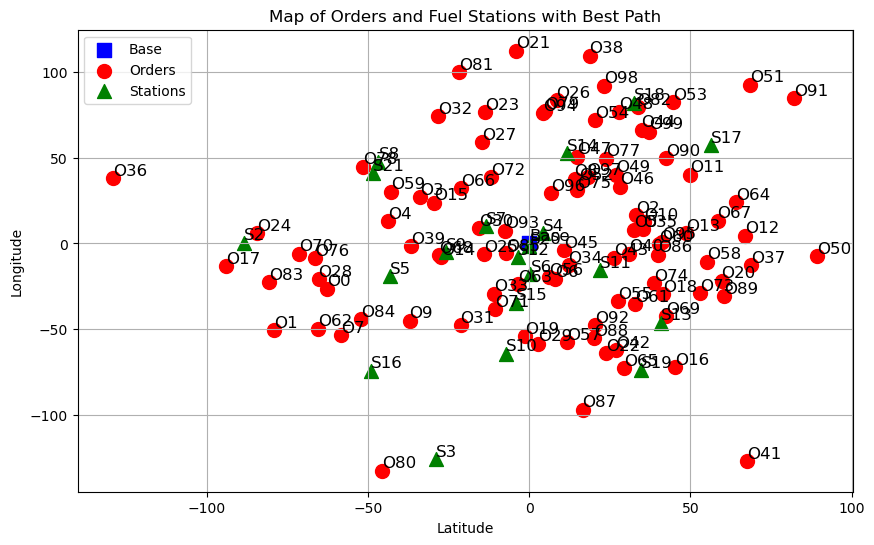

In [867]:
plot_world(df_orders, df_stations, base_location, [])

In [868]:
# Preprocess orders
df_orders.index = generate_orders_indices(len(df_orders))

# display(df_orders.head())

# Preprocess stations
df_stations.loc[0] = {'StationID': int(0), 'Latitude': float(0.0), 'Longitude': float(0.0)}
df_stations.loc[1] = {'StationID': 0, 'Latitude': 0.0, 'Longitude': 0.0}

# display(df_stations.head())

In [869]:
population_size = 100
max_generations = 100

start_population = generate_starting_population(df_stations, df_orders, population_size, print_results=False)

final_population, sample_history = GA_prob(start_population, max_generations, population_size=population_size, print_results=True)
# GA_tournament(start_population, max_generations)


GENERATION: 0
[0, 'CA', 1, 'BZ', 12, 'AD', 8, 'DV', 4, 'AV', 12, 'AR', 1, 'BG', 2, 'BQ', 1, 'CC', 1, 'BI', 12, 'BM', 1, 'AX', 1, 'DA', 1, 'DI', 9, 'CI', 1, 'BD', 1, 'AC', 9, 'DC', 4, 'BJ', 1, 'CP', 3, 'DG', 1, 'BS', 14, 'CE', 1, 'AT', 21, 'DB', 4, 'BL', 10, 'AL', 1, 'BV', 1, 'DR', 4, 'DT', 19, 'CZ', 20, 'AG', 12, 'DF', 1, 'CB', 9, 'CK', 1, 'DS', 4, 'AO', 5, 'DN', 7, 'CR', 13, 'AA', 1, 'BA', 14, 'CO', 1, 'CL', 1, 'AW', 17, 'BP', 1, 'CN', 1, 'CV', 1, 'DD', 3, 'AS', 1, 'AN', 1, 'DM', 1, 'BF', 1, 'AJ', 1, 'AP', 5, 'AI', 1, 'AK', 1, 'DU', 4, 'DH', 1, 'CQ', 1, 'BN', 2, 'CF', 1, 'BT', 1, 'AQ', 1, 'BK', 1, 'BU', 4, 'AZ', 11, 'AM', 3, 'BC', 1, 'DJ', 1, 'AU', 13, 'AB', 1, 'CW', 1, 'DP', 1, 'BB', 1, 'AE', 8, 'BX', 1, 'BH', 1, 'BY', 1, 'AF', 18, 'CG', 6, 'AH', 1, 'CD', 1, 'BW', 14, 'DO', 11, 'BR', 1, 'BE', 1, 'DQ', 7, 'CM', 17, 'DE', 1, 'CS', 3, 'CJ', 6, 'BO', 16, 'CX', 1, 'CY', 1, 'CT', 15, 'DL', 1, 'CH', 1, 'DK', 1, 'CU', 1, 'AY', 0] results: 288121.5853991161
[0, 'CM', 1, 'DN', 13, 'CB', 1, 'DF

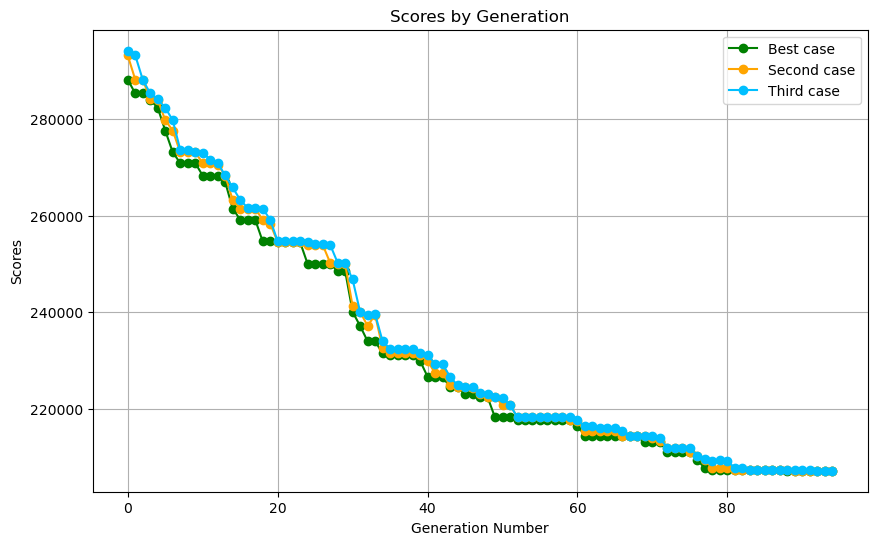

In [870]:
plot_scores(sample_history)

([0, 'DD', 19, 'BK', 5, 'AO', 21, 'AK', 1, 'BA', 1, 'DN', 14, 'BC', 1, 'DI', 6, 'CE', 1, 'AN', 1, 'BM', 5, 'CF', 1, 'AZ', 6, 'DU', 19, 'DH', 1, 'AJ', 13, 'AL', 1, 'BL', 12, 'BB', 18, 'AI', 1, 'CC', 1, 'AV', 1, 'AQ', 20, 'BN', 1, 'BE', 1, 'CN', 6, 'CG', 1, 'BJ', 1, 'DR', 1, 'AS', 1, 'BZ', 1, 'CV', 1, 'AA', 10, 'AG', 1, 'BV', 20, 'AE', 12, 'AC', 1, 'BS', 17, 'DB', 17, 'CP', 1, 'CB', 13, 'AT', 1, 'BR', 7, 'CL', 10, 'DS', 18, 'DM', 3, 'DP', 10, 'AR', 1, 'BP', 6, 'CO', 1, 'CT', 1, 'BD', 1, 'DL', 10, 'CW', 18, 'DE', 19, 'AB', 15, 'CA', 1, 'BF', 12, 'BH', 1, 'BX', 1, 'AX', 1, 'DC', 21, 'DT', 1, 'DV', 1, 'DO', 1, 'DK', 1, 'DJ', 1, 'CJ', 1, 'BQ', 1, 'AW', 11, 'BO', 1, 'AP', 1, 'BG', 1, 'CZ', 8, 'CI', 1, 'CX', 1, 'BW', 1, 'CD', 1, 'AH', 15, 'DA', 14, 'BU', 1, 'AM', 1, 'BY', 1, 'BT', 7, 'CU', 1, 'CR', 1, 'CK', 1, 'CS', 1, 'DG', 2, 'DF', 1, 'CY', 1, 'AY', 1, 'DQ', 1, 'AD', 1, 'CQ', 1, 'BI', 1, 'CH', 8, 'CM', 1, 'AU', 1, 'AF', 0], 207198.36685858408)


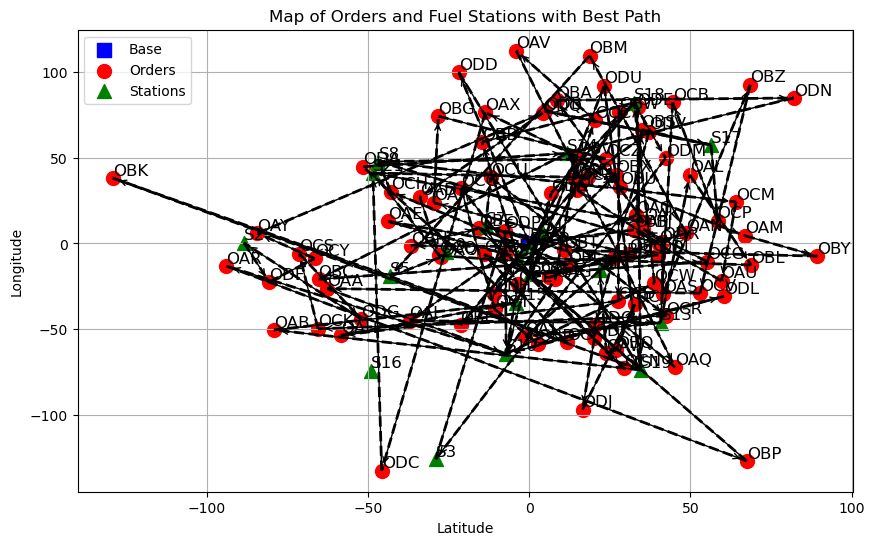

In [871]:
best_path = sample_history[-1][0]
print(best_path)
plot_world(df_orders, df_stations, base_location, best_path[0])